In this demo file, we investigate methods for explainability in medical imaging using pre-trained TorchXRayVision models ( https://github.com/mlmed/torchxrayvision ).

# Setup

In [1]:
!pip install torchxrayvision captum
!git clone https://github.com/mlmed/gifsplanation

import numpy as np
import torchxrayvision as xrv
import skimage, torch, torchvision
import matplotlib.pyplot as plt
import sys,os
sys.path.insert(0,"./gifsplanation/")
#sys.path.insert(0,"./torchxrayvision/torchxrayvision")

from captum.attr import IntegratedGradients, Saliency, InputXGradient
import attribution

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
device

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.0 MB 9.3 MB/s 
     |████████████████████████████████| 1.4 MB 28.8 MB/s 
Cloning into 'gifsplanation'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 217 (delta 1), reused 1 (delta 0), pack-reused 211
Receiving objects: 100% (217/217), 38.47 MiB | 12.57 MiB/s, done.
Resolving deltas: 100% (101/101), done.


'cpu'

# Investigating the models

In the following code cell, we investigate the models included in the TorchXRayVision package. Our ultimate goal is to build an app to help us visualize and interpret model predictions based on the input XRay image. This necessarily requires us to expose the model and access its layers. 

In [2]:
# first, we define a test image
!wget https://raw.githubusercontent.com/mlmed/torchxrayvision/master/tests/16747_3_1.jpg

--2022-09-24 05:23:38--  https://raw.githubusercontent.com/mlmed/torchxrayvision/master/tests/16747_3_1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90480 (88K) [image/jpeg]
Saving to: ‘16747_3_1.jpg’

16747_3_1.jpg       100%[===================>]  88.36K  --.-KB/s    in 0.02s   

2022-09-24 05:23:38 (5.03 MB/s) - ‘16747_3_1.jpg’ saved [90480/90480]



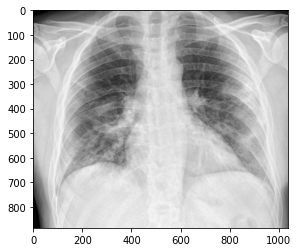

In [3]:
#view the test image
img = skimage.io.imread("16747_3_1.jpg")
img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
img = img.mean(2)[None, ...] # Make single color channel by averaging across the channel dimension, also add an empty batch dimension up front
plt.imshow(img[0], cmap = 'gray')
plt.show()

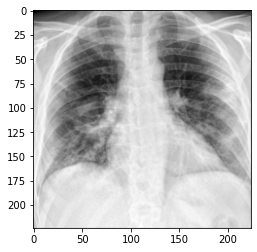

In [4]:
# convert that test image to a torch.tensor compatible with our models, i.e., size = (224,224)
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])
img = transform(img)
img = torch.from_numpy(img)

plt.imshow(img.numpy()[0], cmap = 'gray') #resized image
plt.show()

In [5]:
# Load a model
model_names = ["densenet121-res224-all", "densenet121-res224-rsna", "densenet121-res224-nih",
               "densenet121-res224-pc", "densenet121-res224-chex", "densenet121-res224-mimic_nb", 
               "densenet121-res224-mimic_ch", "resnet50-res512-all"]
model = xrv.models.DenseNet(weights=model_names[0]).to(device)
model.eval()
print(model)

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]
XRV-DenseNet121-densenet121-res224-all


In [6]:
preds = model(img[None,...])
# the model predictions are in logits, i.e., before the soft max layer.  
dict(zip(model.pathologies,preds[0].detach().numpy()))
# This information should be presented as a horizontal bar chart

{'Atelectasis': 0.32797316,
 'Consolidation': 0.42933318,
 'Infiltration': 0.5316924,
 'Pneumothorax': 0.28849724,
 'Edema': 0.024142697,
 'Emphysema': 0.5011832,
 'Fibrosis': 0.51887786,
 'Effusion': 0.27805617,
 'Pneumonia': 0.18569896,
 'Pleural_Thickening': 0.24489869,
 'Cardiomegaly': 0.3645513,
 'Nodule': 0.68981993,
 'Mass': 0.63928443,
 'Hernia': 0.009938776,
 'Lung Lesion': 0.0111506935,
 'Fracture': 0.51916164,
 'Lung Opacity': 0.59073937,
 'Enlarged Cardiomediastinum': 0.27218717}

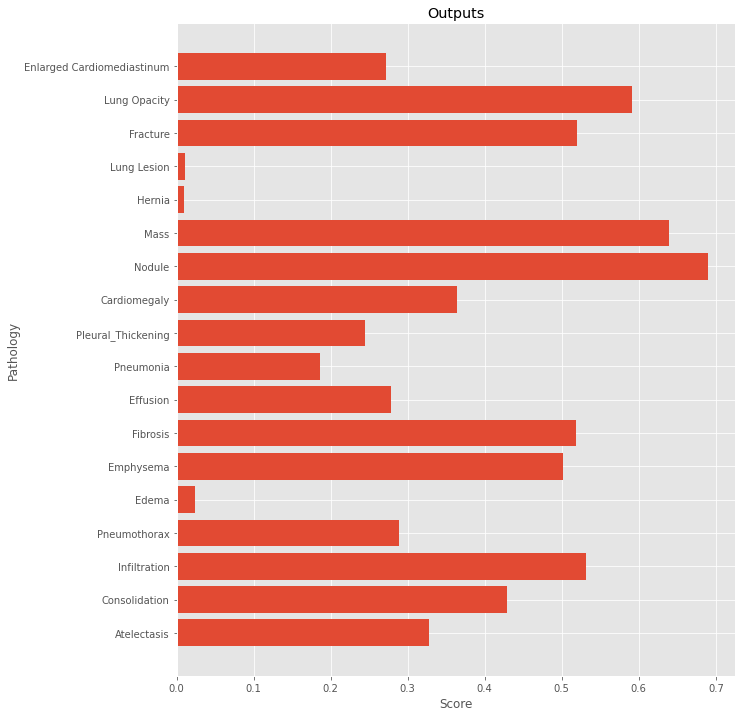

In [7]:
plt.figure(figsize=(10, 12))
plt.style.use('ggplot')
plt.barh(model.pathologies,preds[0].detach().numpy())
plt.title('Outputs')
plt.ylabel('Pathology')
plt.xlabel('Score')
plt.show()

# Gradient-based saliency maps

In [8]:
##
## It turns out, we don't actually have to implement these methods by hand. 
## The Captum package has all the functionality we need
##

# def input_gradient(input, model):
#     # Computes the gradient of the model output (logit) wrt the input image;
#     # basically local sensitivity analysis of model predictions wrt input images
#     # input is (num_batch=1,num_channels=1, height, width) to match the model input

#     model.eval() #checking we are in the appropriate mode

#     #no training, so no grads wrt params needed
#     for param in model.parameters():
#         param.requires_grad = False

#     input.requires_grad = True #size (1,1,224,224)

#     preds = model(input)
    
#     output_of_interest = preds.max()
#     ## TODO: In reality, the user may want to see the input gradient wrt other outputs / classes.
#     # This function should also accept an index for which class we want the saliency map.
#     # sorted, indices = preds.sort()
#     # output_of_interest = sorted.squeeze()[-1]
    
#     output_of_interest.backward()
#     #for sensitivities, we are not interested in the sign of the gradient, just its magnitude
#     sens = torch.abs(input.grad) #size (1,1,224,224)
#     sens = (sens - sens.min())/(sens.max()-sens.min()) #normalize local sensitivities for convenience
#     return sens

In [9]:
input = img[None,...]
input.requires_grad_()

saliency = Saliency(model)
sens_attr = saliency.attribute(input, target=preds.argmax())
# in our main implementation, the target should be user defined

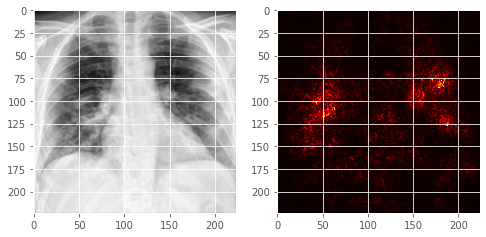

In [10]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(img.numpy()[0], cmap = 'gray') #resized image
plt.subplot(1, 2, 2)
plt.imshow(sens_attr[0,0].numpy(), cmap=plt.cm.hot)
plt.show()

# Gradient X Input Saliency Map

In [11]:
input = img[None,...]
input.requires_grad_()

input_x_gradient = InputXGradient(model)
input_x_gradient_attr = input_x_gradient.attribute(input.to(device), target=preds.argmax())

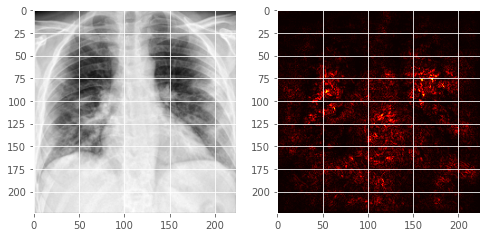

In [12]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(img.numpy()[0], cmap = 'gray') #resized image
plt.subplot(1, 2, 2)
plt.imshow(np.abs(input_x_gradient_attr[0,0].detach().numpy()), cmap=plt.cm.hot)
plt.show()

# Integrated gradient-based saliency maps

In [13]:
input = img[None,...]
input.requires_grad_()

ig = IntegratedGradients(model)
ig_attr = ig.attribute(input.to(device), target=preds.argmax())

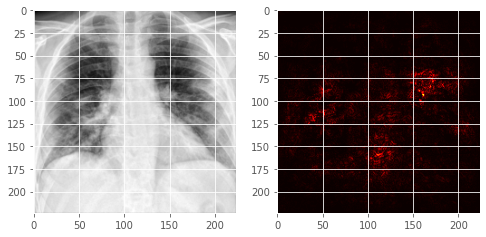

In [14]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(img.numpy()[0], cmap = 'gray') #resized image
plt.subplot(1, 2, 2)
plt.imshow(np.abs(ig_attr[0,0].detach().numpy()), cmap=plt.cm.hot)
plt.show()

# Gifsplanations

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nihpcrsnamimic_ch-resnet101-2-ae-test2-elastic-e250.pt -O /root/.torchxrayvision/models_data/nihpcrsnamimic_ch-resnet101-2-ae-test2-elastic-e250.pt`
[██████████████████████████████████████████████████]
[0.62606514] -1000 0


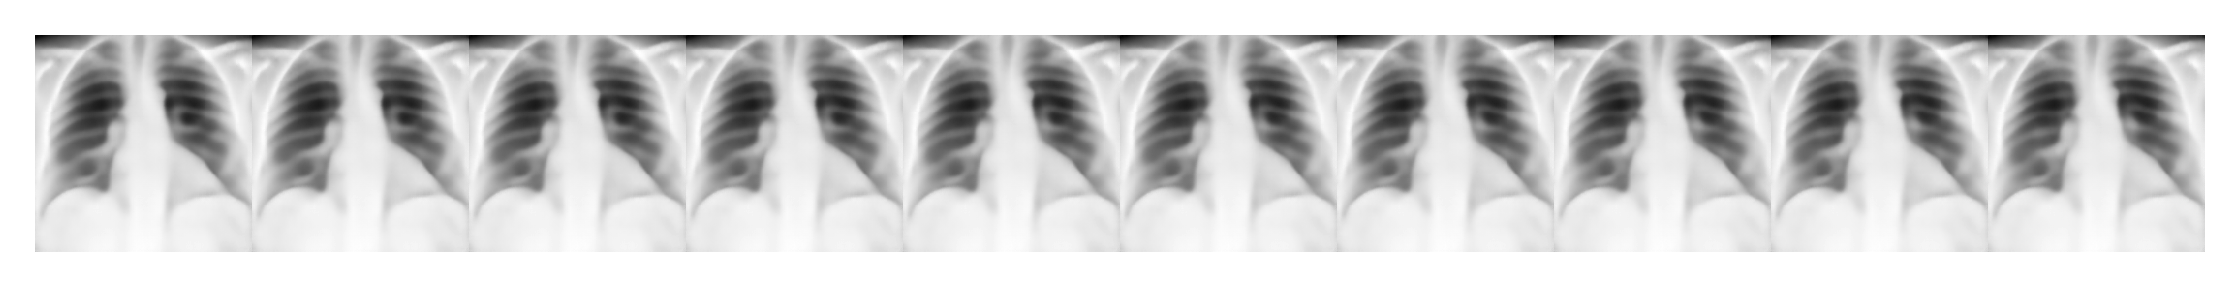

In [15]:
input = img[None,...]
input.requires_grad=False

ae = xrv.autoencoders.ResNetAE(weights="101-elastic").to(device)
target = "Nodule"
params = attribution.compute_attribution(input.to(device), "latentshift", model, target, ret_params=True, ae=ae)

dimgs = np.concatenate(params["dimgs"],1)[0]
fig, ax = plt.subplots(1,1, figsize=(8,3), dpi=350)
plt.imshow(np.concatenate(dimgs,1), interpolation='none', cmap="gray");
plt.axis('off');

In [16]:
%matplotlib inline
attribution.generate_video(input, model, target, ae, target_filename="test", border=False, show=True,
                           ffmpeg_path="ffmpeg")

[0.62606514] -1000 0
0
10
ffmpeg -loglevel quiet -stats -y -i /tmp/gifsplanation/image-%d-a.png -c:v libx264 -vf scale=-2:224 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'
b''
